# **Identificación de Imágenes Auténticas y Sintéticas : Abordando los Desafíos de las Imágenes Sintéticas en la Sociedad Actual**

**Contenido**
1. [Configuración del Entorno](#title1)
2. [Construcción del Conjunto de Datos](#title2)
3. [Creación del Modelo](#title3)

## Configuración del Entorno<a name="title1"></a>

In [1]:
import tensorflow as tf
print(tf.config.experimental.list_physical_devices("GPU"))
print(tf.__version__)
# Para limitar la memoria que usa la GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar TensorFlow para que solo utilice la GPU si es necesario
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Configuración de GPU completada")
    except RuntimeError as e:
        print(e)
# Verifica que la GPU está disponible
print("¿GPU está disponible?:", tf.config.list_physical_devices('GPU'))
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import gc
import tensorflow as tf
from keras import backend as K

# Limpiar la memoria del backend
K.clear_session()
# Forzar la recolección de basura
gc.collect()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.10.0
Configuración de GPU completada
¿GPU está disponible?: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


0

In [2]:
# Limpiar la memoria del backend
K.clear_session()
# Forzar la recolección de basura
gc.collect()

105

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()


## Construcción del Conjunto de Datos y Preprocesandolos<a name="title2"></a>

Fuente: https://www.kaggle.com/datasets/kaustubhdhote/human-faces-dataset & https://www.kaggle.com/datasets/hamzaboulahia/hardfakevsrealfaces/code

In [5]:

# Parámetros
batch_size = 32
img_height = 224  # Requerido por MobileNetV2
img_width = 224
initial_epochs = 10
fine_tune_epochs = 10

# Directorio de datos
data_folder = './Data/All'

# Cargar el dataset completo
full_dataset = image_dataset_from_directory(
    data_folder,
    image_size=(img_height, img_width),
    batch_size=None,  # Cargar todas las imágenes individualmente
    shuffle=True,
    seed=123  # Semilla para reproducibilidad
)

# Capturar class_names antes de aplicar map
class_names = full_dataset.class_names
print("Clases:", class_names)


# Definir preprocesamiento de imágenes
def preprocess(image, label):
    # Convertir a escala de grises
    image = tf.image.rgb_to_grayscale(image)
    # Añadir una dimensión de batch
    image = tf.expand_dims(image, axis=0)  # Ahora tiene forma [1, altura, anchura, 1]
    # Aplicar filtro Sobel
    sobel = tf.image.sobel_edges(image)  # Resultado tiene forma [1, altura, anchura, 1, 2]
    # Reducir dimensiones innecesarias
    sobel = tf.reshape(sobel, [tf.shape(sobel)[1], tf.shape(sobel)[2], 2])
    # Opcional: Combinar las derivadas en una sola magnitud
    sobel_magnitude = tf.sqrt(tf.reduce_sum(tf.square(sobel), axis=-1, keepdims=True))
    # Convertir de nuevo a RGB si el modelo lo requiere
    sobel_rgb = tf.image.grayscale_to_rgb(sobel_magnitude)
    # Aplicar normalización específica de MobileNetV2
    sobel_normalized = preprocess_input(sobel_rgb)
    return image, label

# Aplicar preprocesamiento al dataset
full_dataset = full_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

# Obtener el tamaño total del dataset
dataset_size = tf.data.experimental.cardinality(full_dataset).numpy()
print(f"Tamaño total del dataset: {dataset_size}")

# Definir tamaños para entrenamiento, validación y prueba
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size

# Dividir el dataset
train_dataset = full_dataset.take(train_size)
remaining = full_dataset.skip(train_size)
validation_dataset = remaining.take(val_size)
test_dataset = remaining.skip(val_size)

# Agrupar los datasets
train_dataset = train_dataset.batch(batch_size)
validation_dataset = validation_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

# Aplicar prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 10919 files belonging to 2 classes.
Clases: ['Fake', 'Real']
Tamaño total del dataset: 10919


In [6]:
# Definir aumento de datos
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomBrightness(0.1),
    layers.RandomContrast(0.1),
])

# Cargar el modelo base preentrenado sin las capas superiores
base_model = MobileNetV2(input_shape=(img_height, img_width, 3),
                         include_top=False,
                         weights='imagenet')

# Congelar las capas del modelo base para evitar entrenarlas inicialmente
base_model.trainable = False

# Crear la cabecera personalizada para nuestro problema
global_average_layer = layers.GlobalAveragePooling2D()
prediction_layer = layers.Dense(1, activation='sigmoid')  # Usar sigmoid para clasificación binaria


# Modelo<a name="title3"></a>



In [7]:
# Construcción del modelo
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
# Incrementar Dropout y Regularización
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.005))(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

# Compilar el modelo
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 128)               163968

In [8]:
# Calcular pesos de clase
y_train = np.concatenate([y.numpy() for x, y in train_dataset], axis=0)
class_weights_values = class_weight.compute_class_weight('balanced',
                                                         classes=np.unique(y_train),
                                                         y=y_train)
class_weights = dict(enumerate(class_weights_values))
print(f"Pesos de clase: {class_weights}")

# Definir callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Entrenar el modelo con pesos de clase y callbacks
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=initial_epochs,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
)

# Fine-Tuning: Descongelar más capas del modelo base
base_model.trainable = True
fine_tune_at = 100  # Ajusta este valor según la arquitectura específica

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Compilar el modelo nuevamente con una tasa de aprendizaje más baja
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Continuar el entrenamiento
total_epochs = initial_epochs + fine_tune_epochs
history_fine = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
)


Pesos de clase: {0: 1.0294989224137931, 1: 0.9721444924955482}
Epoch 1/10


ValueError: in user code:

    File "c:\Users\isidr\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\isidr\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\isidr\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\isidr\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\isidr\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\isidr\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 1, 224, 224, 1)


52/52 [==============================] - 4s 29ms/step
Umbral Óptimo: 0.005784898530691862


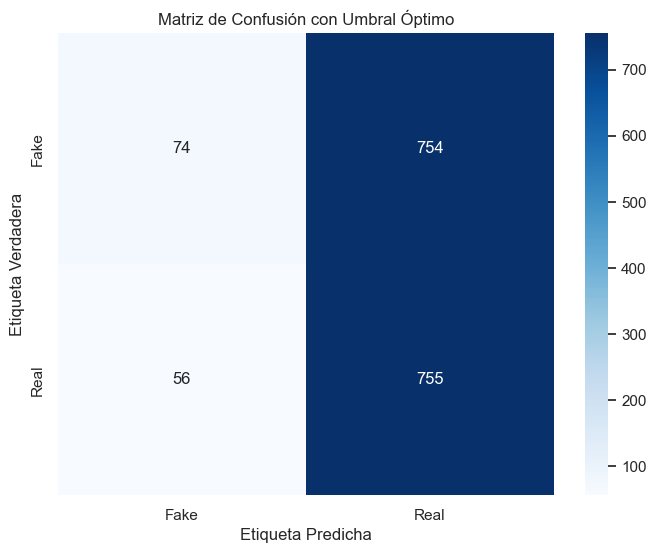


Reporte de Clasificación con Umbral Óptimo:
              precision    recall  f1-score   support

        Fake       0.57      0.09      0.15       828
        Real       0.50      0.93      0.65       811

    accuracy                           0.51      1639
   macro avg       0.53      0.51      0.40      1639
weighted avg       0.54      0.51      0.40      1639

Precisión Global con Umbral Óptimo: 0.5057962172056132


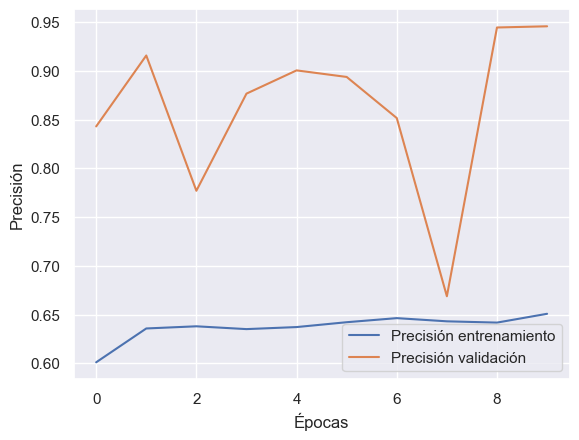

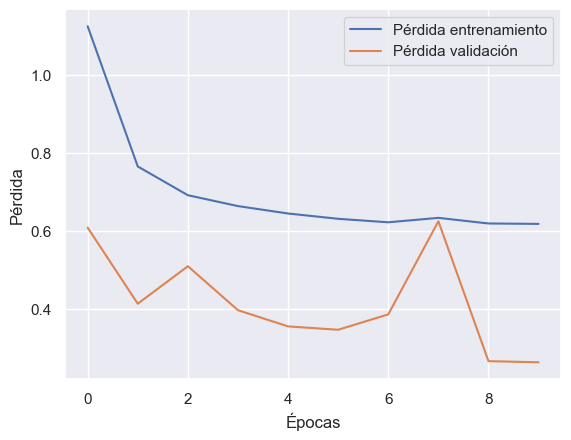

In [13]:
# Métricas
# Métricas

# Generar predicciones
true_labels = np.concatenate([y.numpy() for x, y in test_dataset], axis=0)
predictions = model.predict(test_dataset).ravel()

# Ajustar el umbral óptimo
fpr, tpr, thresholds = roc_curve(true_labels, predictions)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Umbral Óptimo: {optimal_threshold}")

# Aplicar el umbral óptimo
predicted_labels_optimal = (predictions > optimal_threshold).astype(int)

# Matriz de Confusión con umbral óptimo
conf_matrix = confusion_matrix(true_labels, predicted_labels_optimal)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')
plt.title('Matriz de Confusión con Umbral Óptimo')
plt.show()

# Reporte de Clasificación con umbral óptimo
print("\nReporte de Clasificación con Umbral Óptimo:")
print(classification_report(true_labels, predicted_labels_optimal, target_names=class_names))

# Precisión Global con umbral óptimo
accuracy_optimal = accuracy_score(true_labels, predicted_labels_optimal)
print(f"Precisión Global con Umbral Óptimo: {accuracy_optimal}")

# Visualizar los resultados de entrenamiento
plt.plot(history.history['accuracy'], label='Precisión entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Pérdida entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()